# Project 1 - Aurèle Bohbot, Quentin Guilhot, Yanis Tournier

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import pylab as py
from collections import Counter

In [71]:
X = pd.read_csv('X_train.csv').drop(columns=['id'])
Xt = pd.read_csv('X_test.csv')
y = pd.read_csv('y_train.csv')
to_drop = ['x104', 'x129', 'x489', 'x530']
X = X.drop(columns=to_drop)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Handling outliers

In [32]:
avg=X_train.mean()
var=X_train.var()
cov=X_train.cov()

In [ ]:
def detection(df,features):
    outlier_indices=[]
    
    for c in features:
        Q1, Q3 = np.percentile(df[c],25), np.percentile(df[c],75)
        
        #IQR calculation
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        lower_range = Q1 - (outlier_step)
        upper_range = Q3 + (outlier_step)
        
        #Outlier detection                                    #Outlier indexes
        outlier_list_col=df[  (df[c] < lower_range) | (df[c] > upper_range)  ].index
       
        #Store indexes
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices=Counter(outlier_indices)
    # number of outliers
    # If we have more then 2 outliers in a sample, this sample ll be drop
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2 )
    #we are taking indexes
    
    return multiple_outliers

### Handling missing values 

For the moment, we replace the missing values by the column's median. Depending on the results, we might implement a knn algorithm.

In [73]:
X_filled = X_train.fillna(X_train.median())

In [76]:
X_norm = X_filled.copy()
for col in X_filled.columns:
    X_norm[col] = (X_filled[col] - X_filled[col].mean()) / X_filled[col].var()
X_norm

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
806,0.000401,0.001566,0.000971,-1.898010e-04,-0.473492,-0.000480,-0.000385,-0.001698,0.000037,-0.072864,...,0.000144,0.000465,-0.000631,0.195912,0.002024,0.002457,-1.034119,0.004054,0.051652,0.001229
591,-0.000506,0.000010,-0.002455,-6.222288e-05,0.243028,-0.121647,0.000271,-0.002193,-0.005757,-0.609136,...,-0.001448,-0.000333,-0.004205,-0.312476,0.061154,0.000112,0.727801,-0.000689,0.030222,0.001004
361,-0.000017,0.000093,0.002247,-3.355576e-08,-0.006433,0.069583,0.000017,-0.006196,-0.005941,-1.007904,...,-0.000173,0.000086,-0.000989,-0.089989,0.235401,-0.001400,-2.217684,-0.005465,-0.058736,0.000620
266,-0.000227,-0.000022,-0.000640,-1.917863e-04,0.002499,-0.319502,0.000269,-0.005150,-0.006275,-0.917006,...,0.000226,0.000460,0.002538,-0.251294,0.086133,-0.001476,4.535187,-0.001200,0.003431,-0.000651
879,-0.000103,-0.000722,0.001123,7.499469e-05,-0.346855,0.225285,-0.001076,0.006932,0.004788,-0.399058,...,-0.000804,-0.000209,0.003437,-0.384839,-0.163415,-0.004382,-6.492582,0.003093,0.054740,0.000021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,-0.000021,0.000185,-0.000699,-1.442587e-04,-0.306512,-0.074619,0.001326,0.000268,0.001991,-0.036737,...,0.000127,0.000096,-0.000631,0.605737,-0.246015,0.001750,-0.520480,0.000031,0.010332,0.001710
1095,-0.000132,-0.000567,-0.001448,4.730944e-05,-0.298873,-0.045282,-0.002531,0.004641,-0.004720,-0.540256,...,0.000935,0.000117,-0.001329,-0.557548,0.015850,0.001357,5.579982,-0.005231,-0.048276,-0.000989
1130,-0.000309,-0.000030,-0.001530,-3.355576e-08,0.501975,0.017081,-0.000698,-0.000002,0.005510,0.613534,...,-0.000159,0.000536,-0.000631,-0.217634,0.422561,0.000151,1.636514,0.002245,0.042246,0.000203
860,0.000496,0.000957,0.003818,3.365401e-05,0.598835,-0.024605,0.001083,-0.000512,-0.001144,-0.853322,...,-0.002345,0.000550,0.007706,-0.231944,0.589076,0.003152,1.524929,0.003915,-0.008156,-0.002422


### Handling feature selections

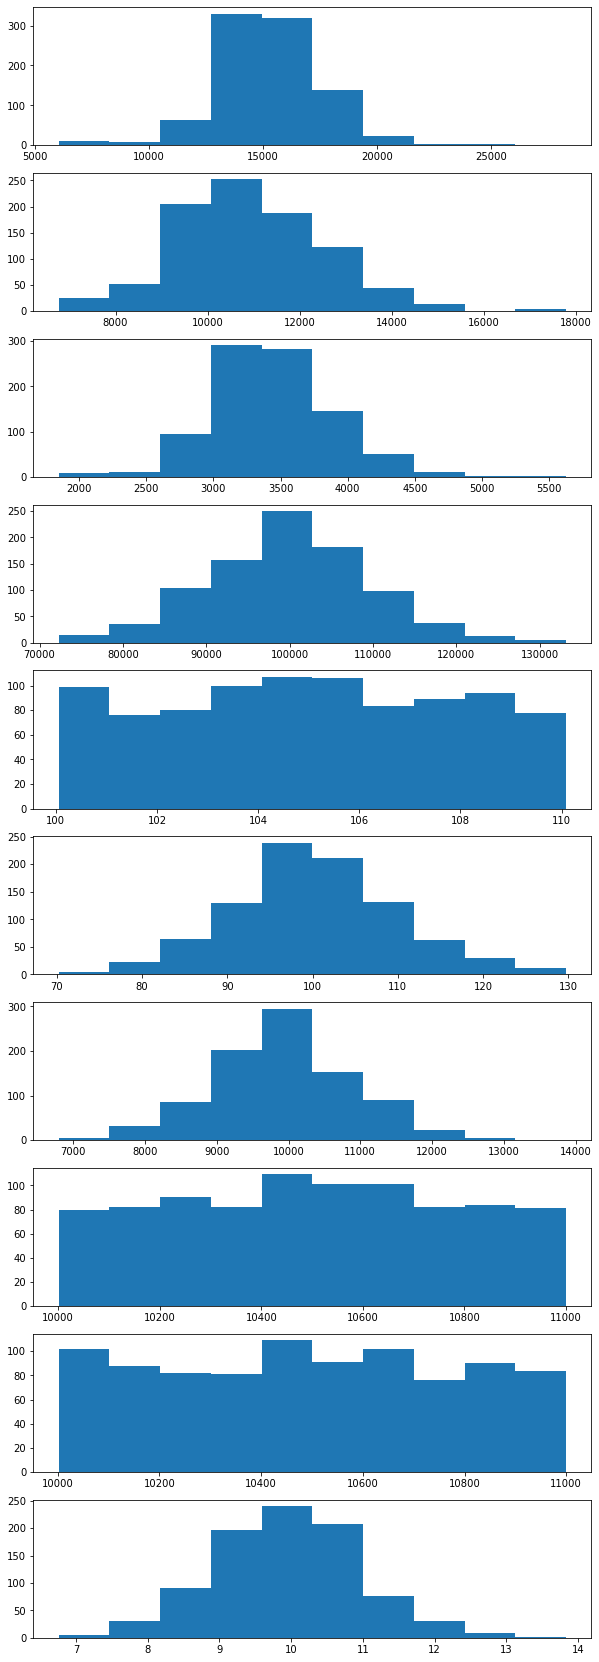

In [77]:
_, axes = plt.subplots(10,1,figsize=(10,30))
for i, feat in enumerate(X_train.columns[:10]):
    axes[i].hist(X_train[feat])
plt.show()

In [50]:
pca=PCA()
pca.fit(X_norm, y_train)
pca.singular_values_

array([1.51411379e+24, 5.69615020e+23, 3.99493191e+15, 4.57395331e+09,
       2.54802472e+09, 2.28142087e+09, 1.93526463e+09, 1.71478764e+09,
       1.54129025e+09, 1.45494335e+09, 1.31360614e+09, 1.22706670e+09,
       1.07292680e+09, 9.34111273e+08, 9.20056344e+08, 7.97570029e+08,
       6.62278470e+08, 6.49213300e+08, 6.46303699e+08, 5.56067192e+08,
       5.02361405e+08, 5.00488802e+08, 4.77129388e+08, 3.87728404e+08,
       3.82949949e+08, 3.66246211e+08, 3.02529492e+08, 2.68810664e+08,
       2.33661785e+08, 2.08425183e+08, 1.42060810e+08, 1.18711785e+08,
       1.18711785e+08, 1.18711785e+08, 1.18711785e+08, 1.18711785e+08,
       1.18711785e+08, 1.18711785e+08, 1.18711785e+08, 1.18711785e+08,
       1.18711785e+08, 1.18711785e+08, 1.18711785e+08, 1.18711785e+08,
       1.18711785e+08, 1.18711785e+08, 1.18711785e+08, 1.18711785e+08,
       1.18711785e+08, 1.18711785e+08, 1.18711785e+08, 1.18711785e+08,
       1.18711785e+08, 1.18711785e+08, 1.18711785e+08, 1.18711785e+08,
      